In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [3]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
if not os.path.exists('../data/imagenet/human_readable_labels.json'):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

In [4]:
# Problem setup
n=25000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage
# Set RAPS regularization parameters (larger lam_reg and smaller k_reg leads to smaller sets)
lam_reg = 0.01 # APS is the special case of RAPS with lam_reg = 0 (or k_reg = smx.shape[1])
k_reg = 5
disallow_zero_sets = False # Set this to False in order to see the coverage upper bound hold
rand = True # Set this to True in order to see the coverage upper bound hold
reg_vec = np.array(k_reg*[0,] + (smx.shape[1]-k_reg)*[lam_reg,])[None,:]

In [15]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

### Conformal prediction happens here

In [16]:
# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = cal_smx.argsort(1)[:,::-1]; 
cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1)
cal_srt_reg = cal_srt + reg_vec
cal_L = np.where(cal_pi == cal_labels[:,None])[1]
cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n),cal_L] - np.random.rand(n)*cal_srt_reg[np.arange(n),cal_L]
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
# Deploy
n_val = val_smx.shape[0]
val_pi = val_smx.argsort(1)[:,::-1]
val_srt = np.take_along_axis(val_smx,val_pi,axis=1)
val_srt_reg = val_srt + reg_vec
val_srt_reg_cumsum = val_srt_reg.cumsum(axis=1)
indicators = (val_srt_reg.cumsum(axis=1) - np.random.rand(n,1)*val_srt_reg) <= qhat
prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)

In [17]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(n_val),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")
print(f"The quantile is: {qhat}")

The empirical coverage is: 0.89744
The quantile is: 0.9477520236694987


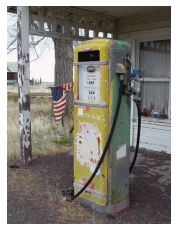

The prediction set is: ['gas pump']


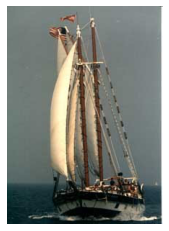

The prediction set is: ['schooner']


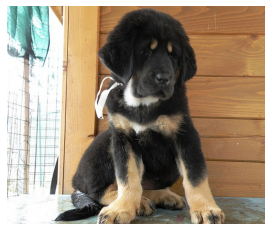

The prediction set is: ['Tibetan Mastiff']


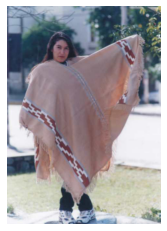

The prediction set is: ['poncho']


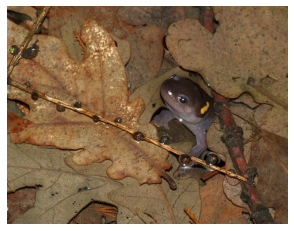

The prediction set is: ['fire salamander', 'spotted salamander', 'tree frog', 'tailed frog']


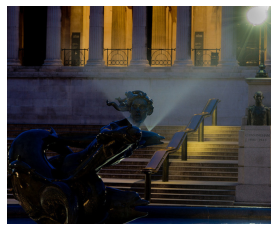

The prediction set is: ['altar', 'baluster', 'cannon', 'church', 'dome', 'fountain', 'grand piano', 'marimba', 'organ', 'palace', 'pier', 'planetarium', 'vault']


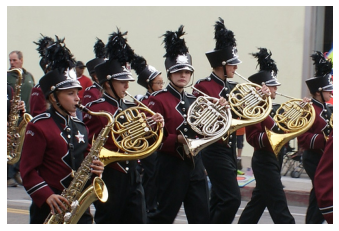

The prediction set is: ['French horn']


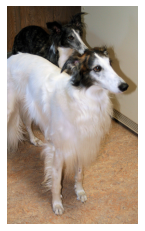

The prediction set is: ['borzoi']


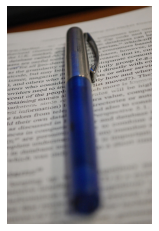

The prediction set is: ['ballpoint pen', 'stethoscope', 'crossword']


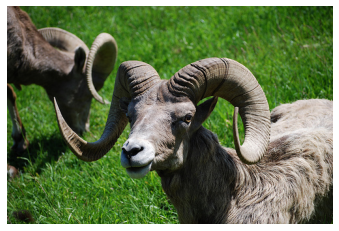

The prediction set is: ['ram', 'bighorn sheep']


In [8]:
# Show some examples
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    # Form the prediction set
    _smx = smx[img_index]
    _pi = np.argsort(_smx)[::-1]
    _srt = np.take_along_axis(_smx,_pi,axis=0)
    _srt_reg = _srt + reg_vec.squeeze()
    _srt_reg_cumsum = _srt_reg.cumsum()
    _ind = (_srt_reg_cumsum - np.random.rand()*_srt_reg) <= qhat
    prediction_set = np.take_along_axis(_ind,_pi.argsort(),axis=0)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")

This method was first introduced in https://arxiv.org/abs/2009.14193.